## Table of Contents


1. [Libraries](#1-Libraries)
2. [Data + Preprocessing](#2-Data-+-Preprocessing)
3. [Dimensionality Reduction](#)

  3.1 [PCA](#)

  3.2 [TSNE](#)

  3.3 [AUTOENCODERS](#)

4. [Train, Validation and Test setss](#)
5. [Modeling](#)

  5.1 [Linear Models](#)

  5.2 [Boosters](#)

  5.3 [Neural Nets](#)

  5.4 [Ensemble based Models](#)

  5.5 [Naive Bayes](#)

  5.6 [Stacked Model](#)

  5.7 [Support Vector Machines (rbf, poly, linear)]()

6. [Evaluation](#)

  6.1 [ROC](#)

  6.2 [FI SCORE](#)

  6.3 [PRECISION AND RECALL](#)


**PS**: The EDA plots can be found [here.](https://dub01.online.tableau.com/#/site/multipleviews/views/BankOfPortugalDemo/Story1/adakibetj@protonmail.com/9f28009e-ae9c-4c3c-97b6-1048156cadbf?:display_count=n&:showVizHome=n&:origin=viz_share_link&:iid=1) 




## 1 Libraries

In [ ]:
# Linear algebra + data processing
import pandas as pd
import numpy as np

# visualisation
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# preprocessing 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers


# statistics
from scipy import stats
from scipy.stats import skew, norm
from statistics import mean 

# models + accuracy metrics
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from lightgbm import LGBMClassifier


# evaluation
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score
from sklearn.metrics import precision_recall_fscore_support as score

# saving models
import pickle
import gzip

# others
import time

# ignore warnings
import warnings
warnings.filterwarnings(action="ignore")

     |████████████████████████████████| 66.1MB 61kB/s 


## 2 Data + Preprocessing


* Involves reading the csv file containing the dataset.  The dataset has the following features: 

  *  *categorical*: **age, job, marital, education, default, housing, loan, contact, month, day_of_week and poutcome.**

  *  *numerical (discrete + continous)*: **duration, campaign, pdays, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m and nr.employed.**

  * *target*:  **y**(term deposit subscription).


* The preprocessing involves the following steps:
  * Imputing null values.
  * Correcting outliers.
  * Feature Generation.
  * Scaling numerical variables.
  * Encoding categorical variables.
  * Resampling the unbalanced dataset.

* And finally we drop the **duration** column and all the features generated from it to avoid data leakage.

In [ ]:
# read and process data
class DataPrep():

  # read the data
  def read_data(self, path):
    data = pd.read_csv(path, sep = ';')
    return data

  # preprocessing
  # def preprocess_data(self, data):
    # categorical + numerical + timestamp columns

  def treat_null(self, data):
    global categorical, discrete, continous, cols
    categorical = []
    discrete = []
    continous = []
    for col in data.columns:
      if data[col].dtype == object:
        categorical.append(col)
      elif data[col].dtype in ['int16', 'int32', 'int64']:
        discrete.append(col)
      elif data[col].dtype in ['float16', 'float32', 'float64']:
        continous.append(col)

    cols = discrete + categorical + continous
    data = data[cols]

    # null values
    # data = preprocess_data(data)
    indices = []
    for col in cols:
      k = data.columns.get_loc(col)
      indices.append(k)

    for col in indices:
      if data.columns[col] in discrete:
        x = data.iloc[:, col].values
        x = x.reshape(-1,1)
        imputer = SimpleImputer(missing_values=np.nan, strategy='median')
        imputer = imputer.fit(x)
        x = imputer.transform(x)
        data.iloc[:, col] = x

      if data.columns[col] in continous:
        x = data.iloc[:, col].values
        x = x.reshape(-1,1)
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        imputer = imputer.fit(x)
        x = imputer.transform(x)
        data.iloc[:, col] = x

      elif data.columns[col] in categorical:
        x = data.iloc[:, col].values
        x = x.reshape(-1,1)
        imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        imputer = imputer.fit(x)
        x = imputer.transform(x)
        data.iloc[:, col] = x     

    return data

  # outlier detection + treatment
  def outlier_correcter(self, data):
    # data = treat_null(data)
    for col in discrete + continous:
      data[col] = data[col].clip(lower=data[col].quantile(0.10), upper=data[col].quantile(0.90))
    return data

  # feature generation
  def generate_features(self, data):
    data['both_loans'] = 0 #default to 0
    data.loc[data['housing'] == 'yes', 'both_loans'] = 1
    data.loc[data['loan'] == 'no', 'both_loans'] = 1 # change to 1 if one has both loans
    data['total_contacts'] = data['campaign'] + data['previous']

    def squares(data, ls):
        m = data.shape[1]
        for l in ls:
            # data = data.assign(newcol=pd.Series(np.log(1.01+data[l])).values)
            data = data.assign(newcol=pd.Series(data[l]*data[l]).values)    
            data.columns.values[m] = l + '_sq'
            m += 1
        return data

    log_features = ['duration', 'cons.price.idx', 'emp.var.rate', 'cons.conf.idx', 'euribor3m']

    data = squares(data, log_features)

    return data

  # scaling numerical
  def scaler(self, data):
    # data = outlier_correcter(data)
    indices = []
    for col in discrete + continous + ['total_contacts', 'duration_sq', 'cons.price.idx_sq', 'emp.var.rate_sq', 'cons.conf.idx_sq', 'euribor3m_sq']:
      k = data.columns.get_loc(col)
      indices.append(k)

      for col in indices:
        x = data.iloc[:, col].values
        x = x.reshape(-1,1)
        imputer = StandardScaler()
        imputer = imputer.fit(x)
        x = imputer.transform(x)
        data.iloc[:, col] = x  

    return data

  # encoding categorical
  def encoder(self, data):
    # data = scaler(data)
    cols = categorical.copy()
    cols.remove('y')
    data = pd.get_dummies(data, columns = cols)
    return data

  # class imbalance
  def over_sample(self, data):
    # data = scaler(data)
    subscribers = data[data.y == 'yes']
    non_subscribers = data[data.y == 'no']

    subscribers_upsampled = resample(subscribers, replace=True, # sample with replacement
                        n_samples = len(non_subscribers), # match number in majority class
                        random_state = 42) # reproducible results

    data = pd.concat([subscribers_upsampled, non_subscribers])
    return data

In [ ]:
# calling the class and its methods
d = DataPrep()
path = '/content/bank-additional-full.csv'
data = d.read_data(path)
print('Original shape:', data.shape)
data = d.treat_null(data)
data = d.outlier_correcter(data)
data = d.generate_features(data)
print('After feature generation:', data.shape)
data = d.scaler(data)
print('After scaling:', data.shape)
data = d.encoder(data)
print('After encoding:', data.shape)
data = d.over_sample(data)
print('After resampling:', data.shape)
data.head()

Original shape: (41188, 21)
After feature generation: (41188, 28)
After scaling: (41188, 28)
After encoding: (41188, 71)
After resampling: (73096, 71)


,age,duration,campaign,pdays,previous,y,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,both_loans,total_contacts,duration_sq,cons.price.idx_sq,emp.var.rate_sq,cons.conf.idx_sq,euribor3m_sq,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
19199,-0.646903,1.434226,0.590509,0.0,-0.397706,yes,0.868654,-0.295178,1.188444,0.777755,0.919962,1,0.486389,1.346195,-0.297736,-0.067174,-1.165015,0.815098,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
39490,1.718737,-0.034880,-0.141306,0.0,2.514421,yes,-1.396626,0.280422,1.188444,-1.533388,-1.624103,1,0.486389,-0.282567,0.277789,1.247132,-1.165015,-1.448870,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
38058,-0.421604,-0.823491,-0.141306,0.0,-0.397706,yes,-1.396626,-1.335031,1.188444,-1.533388,-1.624103,1,-0.239195,-0.699766,-1.332700,1.247132,-1.165015,-1.448870,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0
12904,-1.322801,2.044763,-0.141306,0.0,-0.397706,yes,0.868654,0.599360,-0.512570,0.776575,0.919962,1,-0.239195,2.349067,0.597494,-0.067174,0.475895,0.813189,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
40735,1.718737,-0.187515,-0.873122,0.0,2.514421,yes,-0.901096,1.129667,0.827622,-1.533388,-1.624103,1,-0.239195,-0.388238,1.130349,-0.837275,-0.839913,-1.448870,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1


In [ ]:
# drop duration (to avoid data leakage)
data = data.drop(['duration', 'duration_sq'], axis = 1)

## 3 Dimensionality reduction

**Dimensionality reduction:**


> transformation of data from a high-dimensional space into a low-dimensional space so that the low-dimensional representation retains some meaningful properties of the original data, ideally close to its intrinsic dimension.

In this kernel we explore 3 techniques:


1.  **PCA**:  Principal component analysis is a technique for reducing the dimensionality of datasets, increasing interpretability but at the same time minimizing information loss. It does so by creating new uncorrelated variables that successively maximize variance.

2.  **TSNE**: t-distriuted stochastic neighbor converts similarities between data points to joint probabilities and tries to minimize the [Kullback-Leibler](https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained) divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.In our case, this technique is applied before and after PCA transformation.

3. **AUTOENCODERS**: An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation for a set of data, typically for dimensionality reduction, by training the network to ignore signal “noise”.


The performance of these dimensionality reduction techniques is observed during modeling by matching the accuracies of different transformations with the untransformed dataset.

In [ ]:
# split the data to have the predictor and predicted variables
x = data.drop(['y'], axis = 1)
y = data[['y']]

# Encode labels in target df. 
encoder = LabelEncoder() 
y = encoder.fit_transform(y) 
y = pd.DataFrame(y)
y.columns = ['y']
y.head()

,y
0,1
1,1
2,1
3,1
4,1


### 3.1 PCA

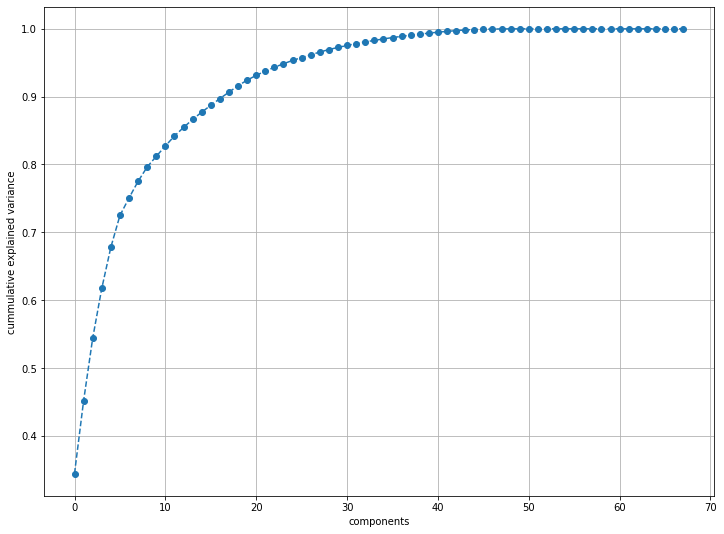

In [ ]:
# pca
pca = PCA()
pca.fit(x)

# get the optimal number of components
plt.figure(figsize = (12,9))
plt.plot(range(68), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.xlabel('components')
plt.ylabel('cummulative explained variance')
plt.grid(True)

In [ ]:
def pca(x):
    pca = PCA(n_components = 8)
    pca.fit(x)
    pca_scores = pca.transform(x)
    return pca_scores

First 8 components hold 80% of the total variation thus a good number to work with.

In [ ]:
# lets get our 8-component df
pca_scores = pca(x)
x_pca = pd.DataFrame(pca_scores)
print(x_pca.shape)
x_pca.head()

(73096, 8)


,0,1,2,3,4,5,6,7
0,-2.340931,0.694888,0.101409,-1.695543,-1.300218,0.725761,-0.563518,-0.922739
1,2.188679,3.137289,1.076142,1.023267,1.469506,-0.431188,-0.529445,0.585185
2,2.423774,1.235087,-0.927898,-1.730621,-1.163028,-0.946711,0.227525,-0.720531
3,-2.372452,-1.422193,-0.100885,0.554204,-1.347001,0.386459,-0.949603,0.378210
4,1.043587,2.964444,0.422771,2.587346,1.522722,-0.123733,0.954169,0.615724


### 3.2 TSNE

In [ ]:
# T-Distributed Stochastic Neighbouring Entities
def tsne(x):
    time_start = time.time()
    tsne = TSNE(n_components = 2, verbose=0, perplexity=40, n_iter=300)  #using 2 components since the barnes_hut algorithm relies on quad-tree or oct-tree.
    tsne_results = tsne.fit_transform(x)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    return tsne_results

#### 3.2.1 TSNE on Original Dataset

In [ ]:
tsne_results = tsne(x)

t-SNE done! Time elapsed: 998.7151763439178 seconds


In [ ]:
x_tsne_org = pd.DataFrame(columns = ['tsne_one', 'tsne_two'])
x_tsne_org['tsne_one'] = tsne_results[:,0]
x_tsne_org['tsne_two'] = tsne_results[:,1]
x_tsne_org.head()

,tsne_one,tsne_two
0,44.059780,-29.043005
1,-21.481403,28.756201
2,32.094521,-9.172636
3,-10.340938,-55.238308
4,-40.738171,38.958412


#### 3.2.2 TSNE on PCA transformed dataset

In [ ]:
tsne_pca_results = tsne(pca_scores)

t-SNE done! Time elapsed: 287.1690123081207 seconds


In [ ]:
x_tsne_pca = pd.DataFrame(columns = ['tsne_pca_one', 'tsne_pca_two'])
x_tsne_pca['tsne_pca_one'] = tsne_pca_results[:,0]
x_tsne_pca['tsne_pca_two'] = tsne_pca_results[:,1]
x_tsne_pca.head()

,tsne_pca_one,tsne_pca_two
0,5.616454,-7.771152
1,1.585083,5.971944
2,6.334506,4.383696
3,2.217092,-2.368316
4,-5.905624,5.222930


Text(0.5, 1.0, 'Scatter plot of the tsne reduction on the pca transformed dataset')

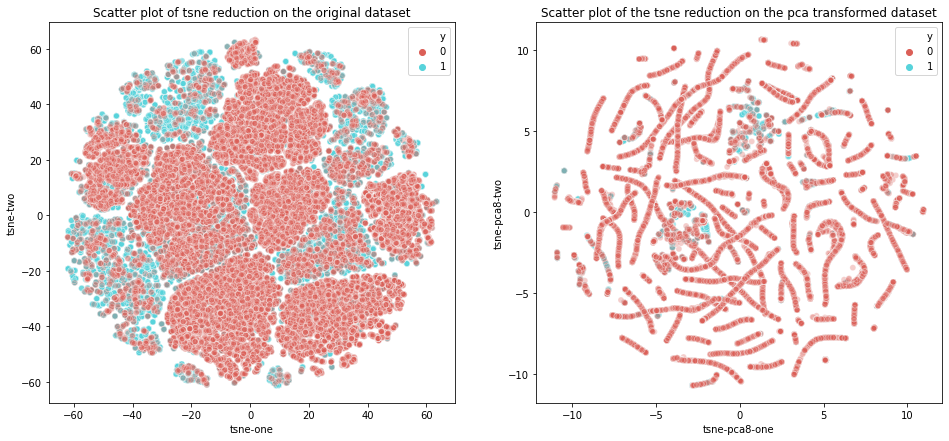

In [ ]:
# visualising the 2 tsne's
df = pd.DataFrame(columns = ['tsne-pca8-one', 'tsne-pca8-two', 'tsne-one', 'tsne-two', 'y'])
df['tsne-pca8-one'] = tsne_pca_results[:,0]
df['tsne-pca8-two'] = tsne_pca_results[:,1]
df['tsne-one'] = tsne_results[:,0]
df['tsne-two'] = tsne_results[:,1]
df['y'] = y.values

plt.figure(figsize=(16,7)).gca(projection='3d')

ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=0.3,
    ax=ax1
).set_title('Scatter plot of tsne reduction on the original dataset')


ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-pca8-one", y="tsne-pca8-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=0.3,
    ax=ax2
).set_title('Scatter plot of the tsne reduction on the pca transformed dataset')


The first plot (tsne on entire dataset) has more datapoints than the 2nd plot (on pca reduced data). 

The clusters are more visible on the 2nd plot and the **no** class is somehow dominating. Recall we oversampled the **yes** class, thus its entries are full of non-unique values, thus the **no** class has less similarities (more variations) in comparison to the **yes** class (less variations) hence less blue clusters.

We'll explore the performance of these 2 + the original PCA reduction in the modelling phase.

### 4.3 AUTOENCODERS

In [ ]:
X_train, X_test, y_train,  y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train = X_train.values
X_test = X_test.values

In [ ]:
# using keras denoise autoencoder

input_dim = x.shape[1]
encoding_dim = 14
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
                    
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=100,
                    batch_size=32,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
   1/1828 [..............................] - ETA: 0s - loss: 0.3841 - accuracy: 0.0625WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1828/1828 [==============================] - 3s 2ms/step - loss: 0.2383 - accuracy: 0.3282 - val_loss: 0.2070 - val_accuracy: 0.4435
Epoch 2/100
1828/1828 [==============================] - 3s 2ms/step - loss: 0.1893 - accuracy: 0.5783 - val_loss: 0.1814 - val_accuracy: 0.6729
Epoch 3/100
1828/1828 [==============================] - 3s 2ms/step - loss: 0.1776 - accuracy: 0.6986 - val_loss: 0.1776 - val_accuracy: 0.6982
Epoch 4/100
1828/1828 [==============================] - 3s 2ms/step - loss: 0.1753 - accuracy: 0.7226 - val_loss: 0.1761 - val_accuracy: 0.7289
Epoch 5/100
1828/1828 [==============================] -

In [ ]:
# lets get our noiseless data.
predictions = autoencoder.predict(X_train)
x_auto = pd.DataFrame(predictions)
x_auto.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67
0,0.037475,0.000000,0.0,2.530036,0.000000,0.000000,0.000000,0.000000,0.000000,0.833727,0.384560,0.000000,1.063654,1.382923,0.000000,0.358818,0.0,0.0,0.027599,0.126914,0.000000,0.000000,0.047334,0.000000,0.133199,0.0,0.0,0.111017,0.799847,0.000000,0.0,0.000000,0.000000,0.000000,0.210456,0.0,0.114532,0.482292,0.056243,1.045971,0.000000,0.0,0.985879,0.021210,0.000000,0.834758,0.0,0.140608,1.251045,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.156051,0.218863,0.253862,0.192759,0.178450,0.936938,0.112541,0.0
1,0.540179,0.000000,0.0,0.000000,0.948258,0.000000,1.183059,0.866081,0.948710,1.012490,0.000000,0.000000,0.000000,0.000000,0.867294,0.269725,0.0,0.0,0.038746,0.094177,0.000000,0.152473,0.043626,0.000000,0.232294,0.0,0.0,0.105887,0.903893,0.000000,0.0,0.076736,0.007168,0.000000,0.168725,0.0,0.157250,0.386539,0.044494,0.780253,0.239603,0.0,0.000000,0.007195,0.985518,0.832568,0.0,0.155790,0.936341,0.000000,0.0,0.970883,0.0,0.0,0.0,0.0,0.00000,0.06185,0.0,0.0,0.145409,0.165634,0.239561,0.224335,0.225465,0.000000,1.018506,0.0
2,1.904014,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.833667,0.000000,0.000000,1.277025,1.518919,0.000000,0.124945,0.0,0.0,0.055120,0.112036,0.882321,0.000000,0.075539,0.000000,0.026949,0.0,0.0,0.095310,1.089219,0.000000,0.0,0.431918,0.031276,0.000000,0.193691,0.0,0.077656,0.148290,0.050995,0.803622,0.000000,0.0,1.009032,0.021706,0.000000,0.816393,0.0,0.157445,0.850981,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.04425,0.00000,0.0,0.0,0.168453,0.255409,0.224028,0.178976,0.173591,0.000000,0.876900,0.0
3,0.000000,1.408746,0.0,0.000000,0.000000,0.000000,1.147522,0.000000,0.000000,0.962711,1.305425,0.000000,1.241254,0.000000,0.000000,0.255472,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.096487,0.037478,0.127700,0.0,0.0,0.056592,0.000000,0.962013,0.0,0.000000,0.065132,0.142460,0.272022,0.0,0.124187,0.191370,0.073377,0.792386,0.060562,0.0,0.000000,0.030523,1.005067,0.802491,0.0,0.165764,0.164464,0.943328,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.275709,0.222703,0.156298,0.189950,0.155586,0.000000,0.970615,0.0
4,0.000000,0.000000,0.0,0.000000,0.173428,0.627774,0.470177,0.414846,0.253278,0.984369,0.000000,0.627563,0.000000,0.000000,0.375600,0.288079,0.0,0.0,0.000000,0.035656,0.000000,0.000000,0.103893,0.107679,0.191400,0.0,0.0,0.069725,0.000000,1.007977,0.0,0.000000,0.054532,0.112259,0.297073,0.0,0.134865,0.290981,0.042848,0.804089,0.156283,0.0,0.000000,0.021303,0.993182,0.820998,0.0,0.153494,0.399207,0.566176,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.178359,0.153034,0.217738,0.198580,0.252820,0.000000,1.033059,0.0


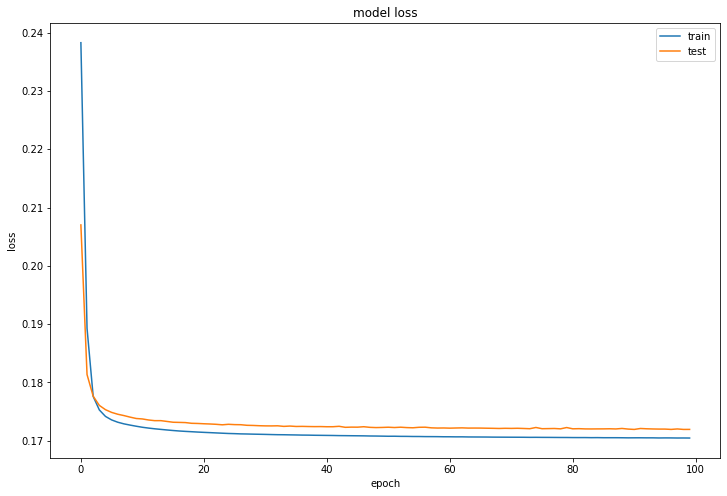

In [ ]:
# evaluation
plt.figure(figsize = (12, 8))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

The 2 converge nicely.

In [ ]:
# close evaluation
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test.y})
error_df.describe()

,reconstruction_error,true_class
count,14620.000000,14620.000000
mean,0.171422,0.503010
std,0.083988,0.500008
min,0.029085,0.000000
25%,0.087725,0.000000
50%,0.186076,1.000000
75%,0.249099,1.000000
max,0.394333,1.000000


The loss looks low enough.

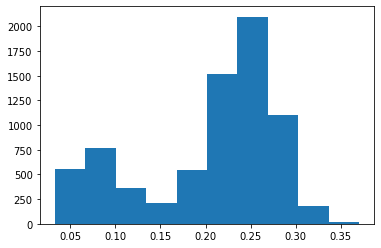

In [ ]:
# reconstruction error with subscription
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 1) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

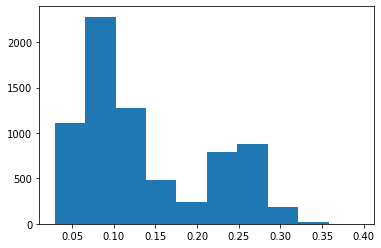

In [ ]:
# reconstruction error without subscription
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

Not really useful in our case.

## 4. Train and Test sets

In [ ]:
# on original dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.10, random_state = 42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((65786, 68), (65786, 1), (7310, 68), (7310, 1))

In [ ]:
# on pca transformed dataset
x_train_pca, x_test, y_train, y_test = train_test_split(x_pca, y, test_size = 0.10, random_state = 42)
x_train_pca.shape, y_train.shape, x_test.shape, y_test.shape

((65786, 8), (65786, 1), (7310, 8), (7310, 1))

In [ ]:
# on tsne (with pca) dataset
x_train_tsne_pca, x_test, y_train, y_test = train_test_split(x_tsne_pca, y, test_size = 0.10, random_state = 42)
x_train_tsne_pca.shape, y_train.shape, x_test.shape, y_test.shape

((65786, 2), (65786, 1), (7310, 2), (7310, 1))

In [ ]:
# on tsne standalone dataset
x_train_tsne, x_test, y_train, y_test = train_test_split(x_tsne_org, y, test_size = 0.10, random_state = 42)
x_train_tsne.shape, y_train.shape, x_test.shape, y_test.shape

((65786, 2), (65786, 1), (7310, 2), (7310, 1))

In [ ]:
# # on autoencoded dataset
# x_train_auto, x_test, y_train, y_test = train_test_split(x_auto, y, test_size = 0.10, random_state = 42)
# x_train_auto.shape, y_train.shape, x_test.shape, y_test.shape

## 5. Modeling

Training algorithms to predict the labels from the predictor features.

Models explored:

* Linear Models
* Boosters
* Neural Nets
* Ensemble based Models
* Naive Bayes
* Stacked Model


***Cross-validation*** is a resampling procedure used to evaluate machine learning models on a limited data sample. The default scoring parameter is **accuracy**.

Techniques: 
1.  **K-fold**: K-Fold CV is where a given data set is split into a K number of sections/folds where each fold is used as a testing set at some point and the rest as the training set.
2.  **Stratified K-fold**: StratifiedKFold shuffles the data, then splits it into n_folds parts then the folds are each used as a testing set.

  Stratification keeps the balance between targets of the dataset. (each stratified subsample should keep the same ratio of the target classes).This strategy often makes the models more stable for subsamples especially in cases of imbalanced data.



In [ ]:
# kfold
kf = KFold(n_splits=10, random_state = 42)
def overall_score(model, x_train):
  accuracy = cross_val_score(estimator = model, X = x_train, y = y_train, cv = kf)
  return accuracy.mean()

#stratified
cv = StratifiedKFold(n_splits=10, random_state=42)
def overall__stratified_score(model, x_train):
  accuracy = cross_val_score(estimator = model, X = x_train, y = y_train, cv = cv)
  return accuracy.mean()

### 5.1 Linear Models

> A linear classifier makes a classification decision based on the value of a linear combination of the features.





#### 5.1.1 Logistic Regression

> To predict group membership, LR uses the log odds ratio rather than probabilities and an iterative maximum likelihood method rather than a least squares to fit the final model. [Read more](https://www.sciencedirect.com/topics/medicine-and-dentistry/logistic-regression-analysis)

In [ ]:
# using grid search to find optimal parameters
regressor = LogisticRegression()
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
model = GridSearchCV(regressor, param_grid=grid_values)

model.fit(x_train,y_train)
print(model.best_score_)
print(model.best_params_)

0.742696036755032
{'C': 1000, 'penalty': 'l2'}


In [ ]:
regressor = LogisticRegression(C = 1000, penalty= 'l2')

# using kfolds
# original dataset
print('Regressor mean score on the original dataset (kfold):', overall_score(regressor, x_train))
# pca transformed
print('Regressor mean score on the pca transformed dataset (kfold):', overall_score(regressor, x_train_pca))
#tsne with pca
print('Regressor mean score on the tsne with pca transformed dataset (kfold):', overall_score(regressor, x_train_tsne_pca))
# tsne solo
print('Regressor mean score on the tsne transformed dataset (kfold):', overall_score(regressor, x_train_tsne))

# stratified KFold
# original dataset
print('Regressor mean score on the original dataset (stratified kfold):', overall__stratified_score(regressor, x_train))
# pca transformed
print('Regressor mean score on the pca transformed dataset (stratified kfold):', overall__stratified_score(regressor, x_train_pca))
#tsne with pca
print('Regressor mean score on the tsne with pca transformed dataset (stratified kfold):', overall__stratified_score(regressor, x_train_tsne_pca))
# tsne solo
print('Regressor mean score on the tsne transformed dataset (stratified kfold):', overall__stratified_score(regressor, x_train_tsne))

Regressor mean score on the original dataset (kfold): 0.7424375220990933
Regressor mean score on the pca transformed dataset (kfold): 0.7184505935323754
Regressor mean score on the tsne with pca transformed dataset (kfold): 0.5311005594655152
Regressor mean score on the tsne transformed dataset (kfold): 0.5577327567454254
Regressor mean score on the original dataset (stratified kfold): 0.7420879248958712
Regressor mean score on the pca transformed dataset (stratified kfold): 0.7185722087345832
Regressor mean score on the tsne with pca transformed dataset (stratified kfold): 0.5328941797775439
Regressor mean score on the tsne transformed dataset (stratified kfold): 0.5574135107740057


### 5.2 Boosters

> ‘Boosting’ refers to a family of algorithms which converts weak learner to strong learners.To find weak rule, base learning (ML) algorithms with a different distribution is applied. Each time base learning algorithm is applied, it generates a new weak prediction rule. This is an iterative process. After many iterations, the boosting algorithm combines these weak rules into a single strong prediction rule. 
[Read more](https://www.analyticsvidhya.com/blog/2015/11/quick-introduction-boosting-algorithms-machine-learning/)

#### 5.2.2 XGBoost
> In gradient boosting, it trains many model sequentially. Each new model gradually minimizes the loss function of the whole system using Gradient Descent method. The learning procedure consecutively fit new models to provide a more accurate estimate of the response variable.
 
> XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

In [ ]:
# using grid search to get the best parameters
xgb = XGBClassifier(silent = True)
optimization_dict = {'max_depth': [2,4,6],
                     'n_estimators': [50,100,200]}

model = GridSearchCV(xgb, optimization_dict, 
                     scoring='accuracy', verbose=1)

model.fit(x_train,y_train)
print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  9.5min finished


0.8025568097043732
{'max_depth': 6, 'n_estimators': 200}


In [ ]:
xgb = XGBClassifier(silent = True,max_depth = 6, n_estimators = 200)

# using kfolds
print('xgb mean score on the original dataset (kfold):', overall_score(xgb, x_train))

# stratified KFold
print('xgb mean score on the original dataset (stratified kfold):', overall__stratified_score(xgb, x_train))

xgb mean score on the original dataset (kfold): 0.8036663132660277
xgb mean score on the original dataset (stratified kfold): 0.8034230551330415


#### 5.2.1 CatBoost
> CatBoost is based on gradient boosting.It converts categorical values into numbers using various statistics on combinations of categorical features and combinations of categorical and numerical features.

In [ ]:
cat = CatBoostClassifier(silent = True)

# using kfolds
# original dataset
print('cat mean score on the original dataset (kfold):', overall_score(cat, x_train))
# pca transformed
print('cat mean score on the pca transformed dataset (kfold):', overall_score(cat, x_train_pca))
#tsne with pca
print('cat mean score on the tsne with pca transformed dataset (kfold):', overall_score(cat, x_train_tsne_pca))
# tsne solo
print('cat mean score on the tsne transformed dataset (kfold):', overall_score(cat, x_train_tsne))

# stratified KFold
# original dataset
print('cat mean score on the original dataset (stratified kfold):', overall__stratified_score(cat, x_train))
# pca transformed
print('cat mean score on the pca transformed dataset (stratified kfold):', overall__stratified_score(cat, x_train_pca))
#tsne with pca
print('cat mean score on the tsne with pca transformed dataset (stratified kfold):', overall__stratified_score(cat, x_train_tsne_pca))
# tsne solo
print('cat mean score on the tsne transformed dataset (stratified kfold):', overall__stratified_score(cat, x_train_tsne))

cat mean score on the original dataset (kfold): 0.8351015889349321
cat mean score on the pca transformed dataset (kfold): 0.8219377085968415
cat mean score on the tsne with pca transformed dataset (kfold): 0.7501441862590973
cat mean score on the tsne transformed dataset (kfold): 0.7747543930259686
cat mean score on the original dataset (stratified kfold): 0.8347064036500782
cat mean score on the pca transformed dataset (stratified kfold): 0.8228802397005573
cat mean score on the tsne with pca transformed dataset (stratified kfold): 0.7494906584985691
cat mean score on the tsne transformed dataset (stratified kfold): 0.7753625476012914


It is clear from these 2 models that the unreduced (original) data yields the best performance, thus in the follow up models, they'll be running only on the original data.

#### 5.2.3 AdaBoost

> It fits a sequence of weak learners on different weighted training data. It starts by predicting original data set and gives equal weight to each observation. If prediction is incorrect using the first learner, then it gives higher weight to observation which have been predicted incorrectly. Being an iterative process, it continues to add learner(s) until a limit is reached in the number of models or accuracy.

In [ ]:
ada = AdaBoostClassifier()

# using kfolds
print('ada mean score on the original dataset (kfold):', overall_score(ada, x_train))

# stratified KFold
print('ada mean score on the original dataset (stratified kfold):', overall__stratified_score(ada, x_train))

ada mean score on the original dataset (kfold): 0.7444287662481918
ada mean score on the original dataset (stratified kfold): 0.7448240855544728


#### 5.2.4 LGBM

> LightGBM improves on XGBoost. The LightGBM paper uses XGBoost as a baseline and outperforms it in training speed and the dataset sizes it can handle.

In [ ]:
# using ridsearch to get the optimal parameters
lgbm = LGBMClassifier()
optimization_dict = {
    'num_leaves': [40, 120],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [30, 50, 100, 300],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
    }

model = GridSearchCV(lgbm, optimization_dict, 
                     scoring='accuracy', verbose=1)

model.fit(x_train,y_train)
print(model.best_score_)
print(model.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 11.0min finished


0.8322743869063716
{'lambda_l1': 0, 'lambda_l2': 0, 'min_data_in_leaf': 50, 'num_leaves': 120, 'reg_alpha': 0.1}


In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(lambda_l1 = 0, lambda_l2 = 0, min_data_in_leaf = 50, num_leaves =120, reg_alpha = 0.1)

# using kfolds
print('lgbm mean score on the original dataset (kfold):', overall_score(lgbm, x_train))
# stratified KFold
print('lgbm mean score on the original dataset (stratified kfold):', overall__stratified_score(lgbm, x_train))

lgbm mean score on the original dataset (kfold): 0.830784601640487
lgbm mean score on the original dataset (stratified kfold): 0.830495790086583


### 5.3 Neural Nets
> Neural networks are forecasting methods that are based on simple mathematical models of the brain. They allow complex nonlinear relationships between the response variable and its predictors.

#### 5.3.1 MultiLayer Perceptron
> A multilayer perceptron (MLP) is a class of feedforward artificial neural network. A MLP consists of at least three layers of nodes: an input layer, a hidden layer and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training. Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable.



In [ ]:
mlp = MLPClassifier()

# using kfolds
print('mlp mean score on the original dataset (kfold):', overall_score(mlp, x_train))
# stratified KFold
print('mlp mean score on the original dataset (stratified kfold):', overall__stratified_score(mlp, x_train))

mlp mean score on the original dataset (kfold): 0.8281142465060725
mlp mean score on the original dataset (stratified kfold): 0.8258342647656853


### 5.4 Ensembling Models
> Ensemble methods use multiple learning algorithms to obtain better predictive performance than could be obtained from any of the constituent learning algorithms alone.

#### 5.4.1 RandomForestClassifier

> It fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. [Read more](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [ ]:

forest = RandomForestClassifier()

# using kfolds
print('forest mean score on the original dataset (kfold):', overall_score(forest, x_train))
# stratified KFold
print('forest mean score on the original dataset (stratified kfold):', overall__stratified_score(forest, x_train))

### 5.5 Naive Bayes
>Naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong independence assumptions between the features. 

#### 5.5.1 Gaussan Naive Bayes
> It's specifically used when the features have continuous values. It's also assumed that all the features are following a gaussian distribution.

In [ ]:
naive_bayes = GaussianNB()

# using kfolds
print('naive_bayes mean score on the original dataset (kfold):', overall_score(naive_bayes, x_train))
# stratified KFold
print('naive_bayes mean score on the original dataset (stratified kfold):', overall__stratified_score(naive_bayes, x_train))

naive_bayes mean score on the original dataset (kfold): 0.7177817318720192
naive_bayes mean score on the original dataset (stratified kfold): 0.7177361299261019


### 5.6 Stacking 
> Stacking is an ensemble method where a new model learns how to best combine the predictions from multiple existing models.

#### 5.6.1 Stacked Averaged Model

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, x_train, y_train):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(x_train, y_train)

        return self
    
    #Now we do the predictions for cloned models and pick out the mode
    def predict(self, x_train):
        predictions = np.column_stack([
            model.predict(x_train) for model in self.models_
        ])
        m = stats.mode(predictions, axis=1)
        return m[0]

In [ ]:
#averaging models and observing score change.
averaged_models = AveragingModels(models = (forest, lgbm, cat))

In [ ]:
# lets check its perfomance with no kfolds
# on original dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.10, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train ,y_train, test_size = 0.20, random_state = 42)

averaged_models = averaged_models.fit(x_train, y_train)
pred = averaged_models.predict(x_val)

In [ ]:
from sklearn.metrics import accuracy_score
averaged_accuracy = accuracy_score(y_val.values, pred)
averaged_accuracy

0.8423012615899073

In [ ]:
# save the models
def save_zipped_pickle(obj, filename, protocol=-1):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol)
        
save_zipped_pickle(regressor, 'cat.pkl')
save_zipped_pickle(lgbm, 'lgbm.pkl')
save_zipped_pickle(forest, 'forest.pkl')
save_zipped_pickle(forest, 'mlp.pkl')
save_zipped_pickle(averaged_models, 'averaged_models.pkl')


# # reload zipped pickle
# def load_zipped_pickle(filename):
#     with gzip.open(filename, 'rb') as f:
#         loaded_object = pickle.load(f)
#         return loaded_object

### 5.7 Support Vector Machines (rbf, poly, linear)
> Support Vector Machine is a linear model for classification and regression problems. It can solve linear and non-linear problems. The idea of SVM is simple: The algorithm creates a line or a hyperplane which separates the data into classes.

#### 5.7.1 Linear
> LinearSVM is a linearly scalable routine meaning that it creates an SVM model in a CPU time which scales linearly with the size of the training data set

In [ ]:
# linear
ls =  LinearSVC(tol=1e-5)

# using kfolds
print('LinearSVC mean score on the original dataset (kfold):', overall_score(ls, x_train))
# stratified KFold
print('LinearSVC mean score on the original dataset (stratified kfold):', overall__stratified_score(ls, x_train))

LinearSVC mean score on the original dataset (kfold): 0.7425704268657516
LinearSVC mean score on the original dataset (stratified kfold): 0.7426654658248641


#### 5.7.2 rbf

In [ ]:
# # rbf
# rbf =  SVC(kernel = 'rbf')

# # using kfolds
# print('rbf mean score on the original dataset (kfold):', overall_score(rbf, x_train))
# # stratified KFold
# print('rbf mean score on the original dataset (stratified kfold):', overall__stratified_score(rbf, x_train))

#### 5.7.2 poly

In [ ]:
# # poly
# poly =  SVC(kernel = 'poly')

# # using kfolds
# print('poly mean score on the original dataset (kfold):', overall_score(poly, x_train))
# # stratified KFold
# print('poly mean score on the original dataset (stratified kfold):', overall__stratified_score(poly, x_train))

## 7 Evaluation
Model evaluation is necessary to determine how well the model will perform in carrying out predictions.

Metrics:
1. **ROC** - ROC curve is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0. 

2. **F1 SCORE** -  F1 score (also F-score or F-measure) is a measure of a test's accuracy. It is calculated from the precision and recall of the test, where the precision is the number of correctly identified positive results divided by the number of all positive results, including those not identified correctly, and the recall is the number of correctly identified positive results divided by the number of all samples that should have been identified as positive. 

3. **PRECISION AND RECALL**.


> ROC curves should be used when there are roughly equal numbers of observations for each class.
Precision-Recall curves should be used when there is a moderate to large class imbalance.

> Since we resampled our data to be balanced, ROC is our best take.




In [ ]:
# predictions
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.10, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train ,y_train, test_size = 0.20, random_state = 42)


cat = cat.fit(x_train, y_train)
c_pred = cat.predict(x_val)
forest = forest.fit(x_train, y_train)
f_pred = forest.predict(x_val)
lgbm = lgbm.fit(x_train, y_train)
l_pred = lgbm.predict(x_val)
avg_pred = averaged_models.predict(x_val)

### 7.1 ROC

RandomForest: 0.9938778824545019
CatBoost:  0.9145060440126584
LGBM: 0.8704989314766184


Text(0, 0.5, 'True Positive Rate')

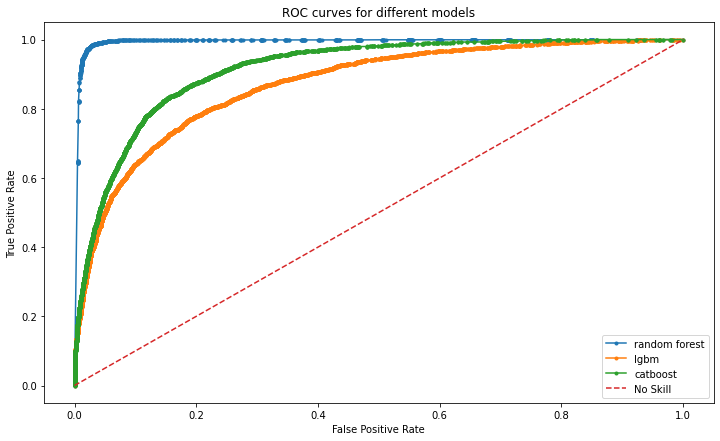

In [ ]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#predict probabilities
ns_probs = [0 for _ in range(len(x_val))]  # no skill classifier
f_prob = forest.predict_proba(x_val)
c_prob = cat.predict_proba(x_val) 
l_prob = lgbm.predict_proba(x_val)

# keep probabilities for the positive outcome only
f_prob = f_prob[:, 1]
c_prob = c_prob[:, 1]
l_prob = l_prob[:, 1]

# calculate scores then print them
f_auc = roc_auc_score(y_val, f_prob)
c_auc = roc_auc_score(y_val, c_prob)
l_auc = roc_auc_score(y_val, l_prob)
ns_auc = roc_auc_score(y_val, ns_probs)
print('RandomForest:', f_auc)
print('CatBoost: ', c_auc)
print('LGBM:', l_auc)

# calculate roc curves
f_fpr, f_tpr, _ = roc_curve(y_val, f_prob)
c_fpr, c_tpr, _ = roc_curve(y_val, c_prob)
l_fpr, l_tpr, _ = roc_curve(y_val, l_prob)
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)

# plot the roc curve for the model
plt.figure(figsize = (12,7))
plt.plot(f_fpr, f_tpr, marker='.', label='random forest')
plt.plot(l_fpr, l_tpr, marker='.', label='lgbm')
plt.plot(c_fpr, c_tpr, marker='.', label='catboost')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

plt.legend()
plt.title('ROC curves for different models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

Like the accuracy scores, Random Forest classifier performs best. (Makes me think the model is overfitting though).

A no-skill classifier is one that cannot discriminate between the classes and would predict a random class or a constant class in all cases. (Our benchmark).

### 7.2 F1 Score

In [ ]:
print('cat:', f1_score(c_pred, y_val))
print('forest:', f1_score(f_pred, y_val))
print('lgbm:', f1_score(l_pred, y_val))
print('averaged_models:', f1_score(avg_pred, y_val))

cat: 0.8243492190628756
forest: 0.9604511389775173
lgbm: 0.7518515365625266
averaged_models: 0.8327287384119307


### 7.3 Precision and Recall

In [ ]:
# cat boost
precision, recall, fscore, support = score(y_val, c_pred)

print('precision: {}'.format(mean(precision)))
print('recall: {}'.format(mean(recall)))
print('fscore: {}'.format(mean(fscore)))
print('support: {}'.format(mean(support)))

precision: 0.8353606863292833
recall: 0.8327894876183073
fscore: 0.8328961770247499
support: 6579


In [ ]:
# forest
precision, recall, fscore, support = score(y_val, f_pred)

print('precision: {}'.format(mean(precision)))
print('recall: {}'.format(mean(recall)))
print('fscore: {}'.format(mean(fscore)))
print('support: {}'.format(mean(support)))

precision: 0.9617019312570101
recall: 0.9600036311840093
fscore: 0.959468501181258
support: 6579


In [ ]:
# lgbm
precision, recall, fscore, support = score(y_val, l_pred)

print('precision: {}'.format(mean(precision)))
print('recall: {}'.format(mean(recall)))
print('fscore: {}'.format(mean(fscore)))
print('support: {}'.format(mean(support)))

precision: 0.7887290012566746
recall: 0.7771402408602204
fscore: 0.7758845849467859
support: 6579


In [ ]:
# averaged
precision, recall, fscore, support = score(y_val, avg_pred)

print('precision: {}'.format(mean(precision)))
print('recall: {}'.format(mean(recall)))
print('fscore: {}'.format(mean(fscore)))
print('support: {}'.format(mean(support)))

precision: 0.8451168471273891
recall: 0.8416759058046743
fscore: 0.84178310258243
support: 6579


Random forest has the highest precision, recall and fscore in comparison to the best models evaluated. It's accuracy is through the roof making one think of overfitting. So we're gonna run predictions using the randomforest and the averaged model.

## 8. Prediction

In [ ]:
# Random Forest
pred = forest.predict(x_test)
pred_df = pd.DataFrame(pred)
pred_df.columns = ['y']
print(x_test.shape)
print(pred_df.shape)
pred_df.head()

(7310, 68)
(7310, 1)


,y
0,0
1,1
2,1
3,0
4,0


In [ ]:
precision, recall, fscore, support = score(y_test, pred)

print('precision: {}'.format(mean(precision)))
print('recall: {}'.format(mean(recall)))
print('fscore: {}'.format(mean(fscore)))
print('support: {}'.format(mean(support)))

precision: 0.9608525296205217
recall: 0.958267537528031
fscore: 0.9580856917744027
support: 3655


Accuracy just as we expected.

In [ ]:
# averaged model
pred = averaged_models.predict(x_test)
pred_df_avg = pd.DataFrame(pred)
pred_df_avg.columns = ['y']
pred_df_avg.to_csv('pred_df_avg.csv')